In [20]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import interp


In [2]:
df = pd.read_csv('ecs171.dataset.txt', delim_whitespace=True, header=0, index_col=0)
gene_ex = df.iloc[:, 5:]
growth = df[['GrowthRate']]
data = df[['GrowthRate', ]]

In [3]:
gene_ex.isnull().values.any()

True

In [4]:
#column had too many NAN values
gene_ex = gene_ex.drop(['b4635'], axis=1)

In [5]:
#no missing values
gene_ex.isnull().values.any()

False

In [6]:
#Removed columns that consisted only of zeros
gene_noz = gene_ex.loc[:, (gene_ex != 0).any(axis=0)]

In [7]:
growth.head()


,GrowthRate
ID,
T8129,0.637
T8130,0.637
T8131,0.637
T8135,0.724
T8136,0.724


# Problem 1

In this data set we have a large amount of features. On top of that not all of
these features might be as informative in regards to bacterial growth. Using
all of these features would probably result in over-fitting. Ridge and Lasso
regression are methods that allow us to reduce the model complexity, reduce features, and thus improve results when predicting.

## Ridge Regression
Asuming the cost funciton is MSE(Mean Squared Error) ridge regression would modify the cost function by adding a
penalty in the form of
\begin{equation*}
\lambda \sum_{j=0}^n w_j^2 
\end{equation*}
This constraint shrinks the weights and helps reduce the overall complexity of the model.

## Lasso Regression
In Lasso regression a penalty is applied to the "error" or "cost" function of predicting. Penalty is usually in the form of 
\begin{equation*}
\lambda \sum_{j=0}^n \lvert w_j\rvert 
\end{equation*}
The more the weights and the larger the weight value the larger the penalty is.
In order to reduce penalty weight values must shrink or reduce the amount of
features(complexity) of the model. This L1 type of regularization can help
reduce overfitting and since we can have zero weights it also helps reduce
features

In [8]:
#Genreate list of alphas(lambda) that we will use to test
alphas = np.arange(0.01, 1.01, .01)

def findBestAlpha(model, params, X, Y):
    parameters = {'alpha': params}
    model_reg = GridSearchCV(model, parameters, scoring='r2', cv=5, iid=False)
    model_reg.fit(X, Y)
    best = {
        'best_param': model_reg.best_params_,
        'best_score(r^2)': model_reg.best_score_,
        'best_est': model_reg.best_estimator_
    }
    return best

In [9]:
#testing for ridge
r = Ridge()
ridge_res = findBestAlpha(r, alphas, gene_ex, growth)

#testing for lasso
l = Lasso()
lasso_res = findBestAlpha(l, alphas, gene_ex, growth)

## Ridge Results

In [11]:
#Number of non zero coeffeciets and 5-fold error
#ridge
r = ridge_res['best_est']
ridge_weights = r.coef_
ridge_weights = ridge_weights[0]
r_nz = np.count_nonzero(ridge_weights)
print('Ridge num of non-zero: ', r_nz)
print('Ridge best alpha: ', ridge_res['best_param']['alpha'])
#Error
negMSE = cross_val_score(r, gene_ex, growth, cv=5, scoring='neg_mean_squared_error')
MSE = np.negative(negMSE)
mean_MSE = np.mean(MSE)
print('MSE: ', mean_MSE)

Ridge num of non-zero:  4434
Ridge best alpha:  0.25
MSE:  0.01202547557741835


## Lasso Results

In [12]:
#Number of non zero coeffeciets and 5-fold error
#ridge
l = lasso_res['best_est']
lasso_weights = l.coef_
l_nz = np.count_nonzero(lasso_weights)
print('Lasso num of non-zero: ', l_nz)
print('Lasso best alpha: ', lasso_res['best_param']['alpha'])

#Error
negMSE = cross_val_score(l, gene_ex, growth, cv=5, scoring='neg_mean_squared_error')
MSE = np.negative(negMSE)
mean_MSE = np.mean(MSE)
print('MSE: ', mean_MSE)

Lasso num of non-zero:  6
Lasso best alpha:  0.09999999999999999
MSE:  0.053624756617355315


# Problem 2

In [12]:
def bootStrap(model, a, iterations, X, Y, sample):
    preds = list()
    
    for i in range(iterations):
        #split data
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.20)
        
        #fit model
        if(model == 'ridge'):
            m = Ridge(alpha=a)
        elif(model == 'lasso'):
            m = Lasso(alpha=a)
        else:
            print('Not valid Model')
            break
        m.fit(x_train, y_train)
        
        #predict
        prd = m.predict(sample)
        #print('Prediction: ', prd)
        if(model == 'ridge'):
            preds.append(prd[0][0])
        else:
            preds.append(prd[0])
    
    pyplot.hist(preds)
    pyplot.show
    
    #confidence 95% interval
    conf = 0.95
    p = ((1-conf)/2.0) * 100
    lower = max(0.0, np.percentile(preds, p))
    p = (conf+((1.0-conf)/2.0))*100
    upper = min(1.0, np.percentile(preds, p))
    print('%.1f%% confidence interval %.3f and %.3f' % (conf*100, lower, upper))
    

# Problem 3

In [13]:
samp = gene_ex.mean().values
samp = samp.reshape(1, -1)

## Bootstrap for Ridge

95.0% confidence interval 0.390 and 0.398


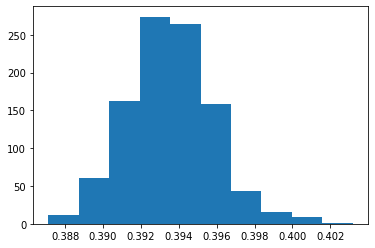

In [14]:
ridge_alpha = ridge_res['best_param']['alpha']
bootStrap('ridge', ridge_alpha, 1000, gene_ex, growth, samp)

## Bootstrap for Lasso

95.0% confidence interval 0.377 and 0.409


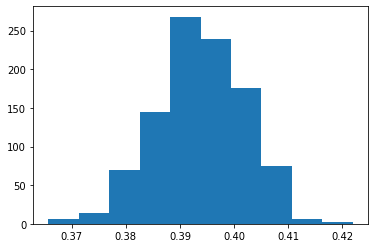

In [15]:
lasso_alpha = lasso_res['best_param']['alpha']
bootStrap('lasso', lasso_alpha, 1000, gene_ex, growth, samp)

# Problem 4

### ROC Curves

In [17]:
def rocCurve(X, Y):
    x_train, x_test, y_train, y_test = train_test_split(reduced, y, test_size=.35, random_state=67)
    #model
    clf = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=7))
    yScore = clf.fit(x_train, y_train).decision_function(x_test)
    
    f = {}
    t = {}
    rocAUC = {}
    for i in range(Y.shape[1]):
        f[i], t[i], _ = roc_curve(y_test[:, i], yScore[:, i])
        rocAUC[i] = auc(f[i], t[i])
    
    f['micro'], t['micro'], _ = roc_curve(y_test.ravel(), yScore.ravel())
    rocAUC['micro'] = auc(f['micro'], t['micro'])
    
    allF = np.unique(np.concatenate([f[i] for i in range(y.shape[1])]))

    meanT = np.zeros_like(allF)
    for i in range(y.shape[1]):
        meanT += interp(allF, f[i], t[i])
    
    meanT = meanT / y.shape[1]

    f['macro'] = allF
    t['macro'] = meanT
    rocAUC['macro'] = auc(f['macro'], t['macro'])
    
    res = {
        'fp': f,
        'tp': t,
        'ROC': rocAUC
    }
    
    return res

In [27]:
def plotROC(r, numC):
    f = r['fp']
    t = r['tp']
    rocAUC = r['ROC']
    lw=4
    plt.figure()
    plt.plot(f['micro'], t['micro'], label='micro-average ROC curve(AUC = {0:0.2f})'
         ''.format(rocAUC['micro']), color='red', linestyle=':', linewidth=4)
    plt.plot(f['macro'], t['macro'], label='macro-average ROC curve(AUC = {0:0.2f})'
         ''.format(rocAUC['macro']), color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.show()
    cmap = plt.get_cmap('gnuplot')
    color = [cmap(i) for i in np.linspace(0, 1, 20)]
    
    for i in range(numC):
            c = 1
            if((c % 3) == 0):
                plt.figure()
                c = 1
            plt.plot(f[i], t[i], color=color[i], lw=lw, label='ROC curve of class {0} (AUC={1:0.2f})'
            ''.format(i, rocAUC[i]))
            plt.plot([0, 1], [0, 1], 'k--', lw=lw)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            plt.show()
            c = c + 1

D:\ANACONDA\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


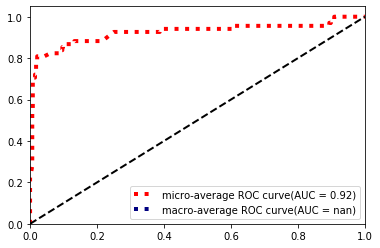

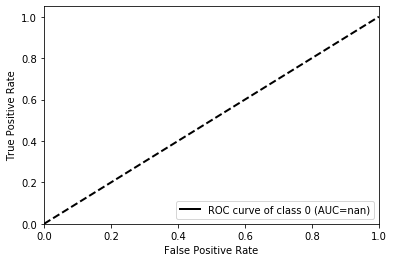

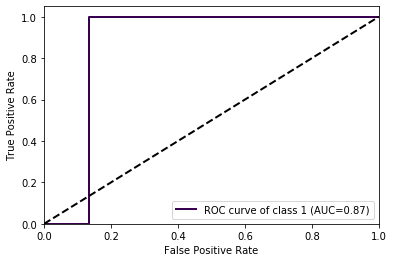

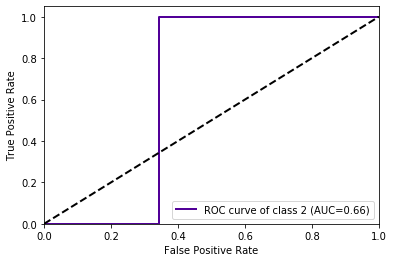

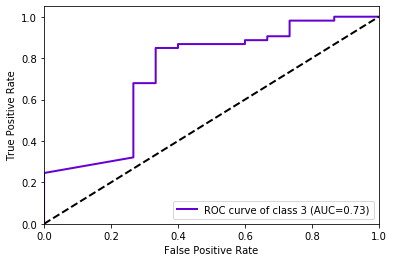

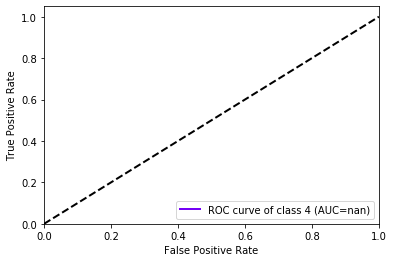

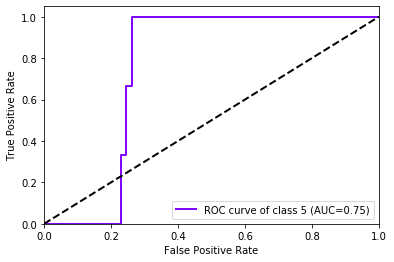

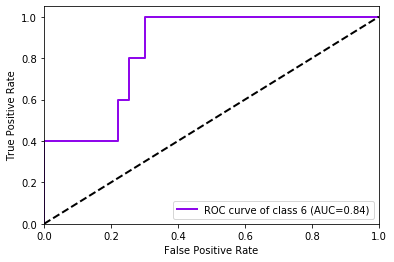

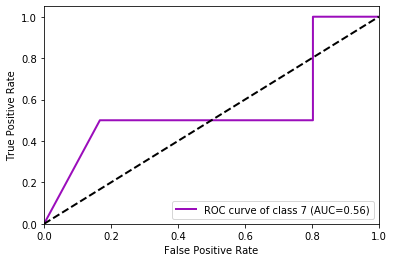

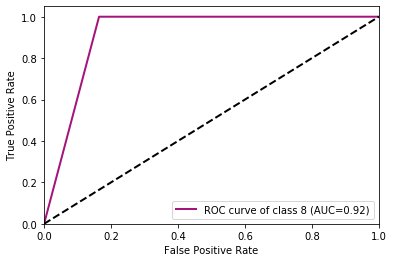

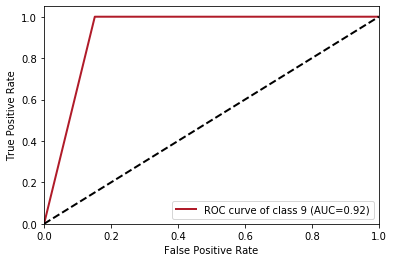

In [147]:
strain = df[['Strain']]
#gene_ex;
y = label_binarize(strain.values, classes=['BW25113', 'CG2', 'DH5alpha', 'MG1655', 'P2', 'P4X', 'W3110', 'rpoA14', 'rpoA27', 'rpoD3'])
#get non-zero features from number 1
l = lasso_res['best_est']
w = l.coef_
w = np.nonzero(w)
w = w[0]
reduced = gene_ex.iloc[:, w]

res = rocCurve(reduced, y)
plotROC(res, y.shape[1])

D:\ANACONDA\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
D:\ANACONDA\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


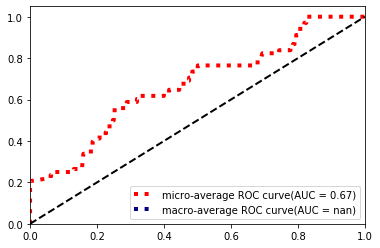

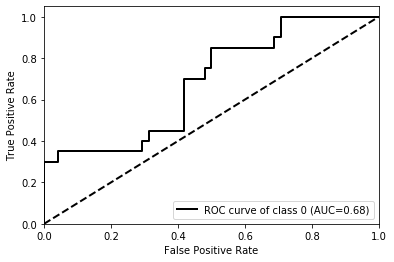

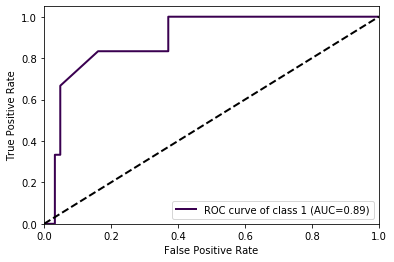

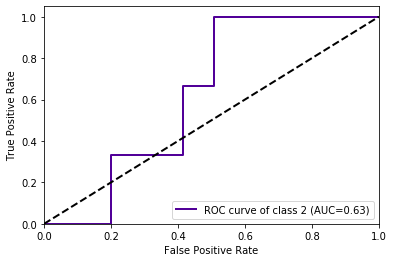

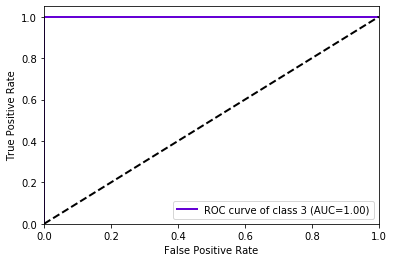

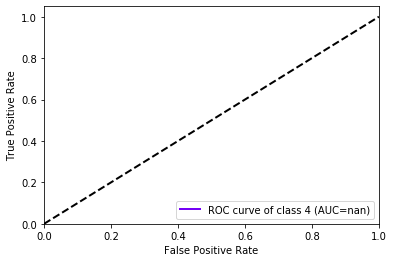

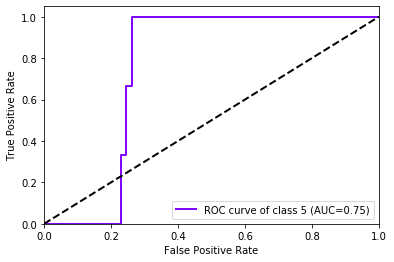

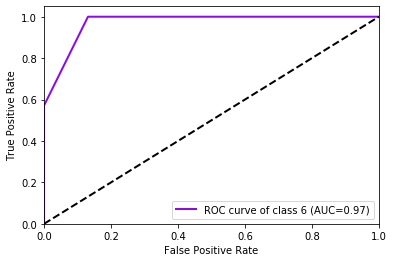

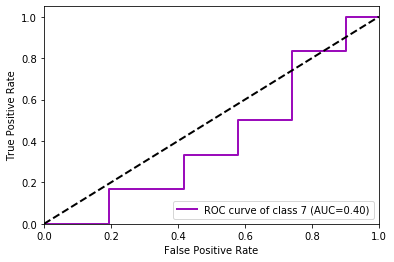

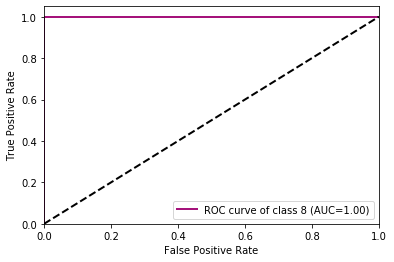

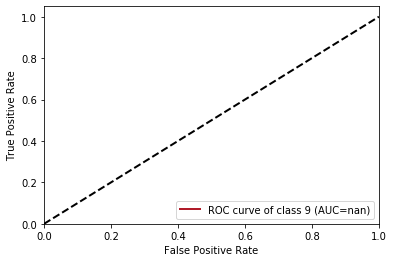

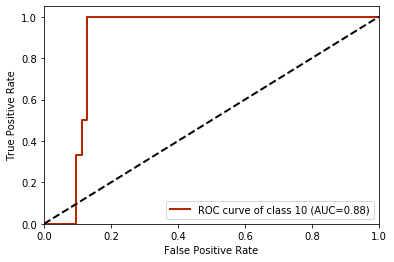

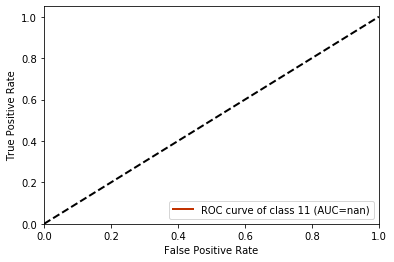

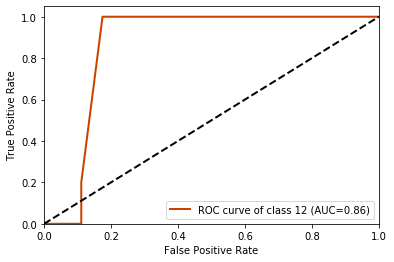

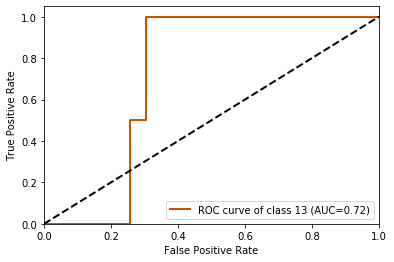

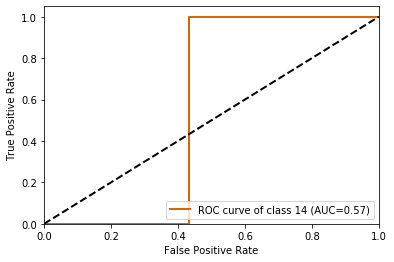

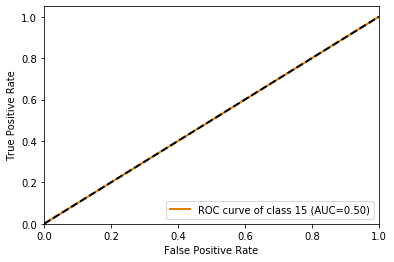

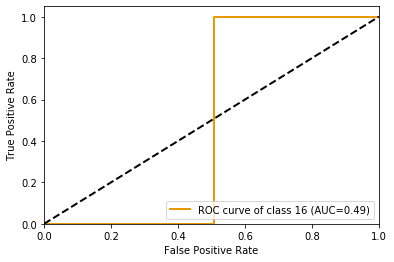

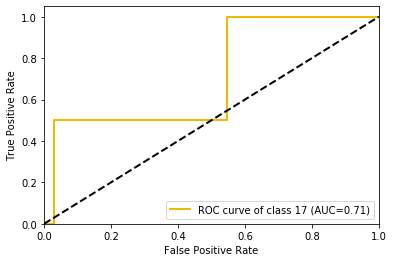

In [148]:
#medium
medium = df[['Medium']]
labels = medium.loc[:, 'Medium'].unique()
labels = list(labels)
#gene_ex;
y = label_binarize(medium.values, classes=labels)

res = rocCurve(reduced, y)
plotROC(res, y.shape[1])


D:\ANACONDA\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


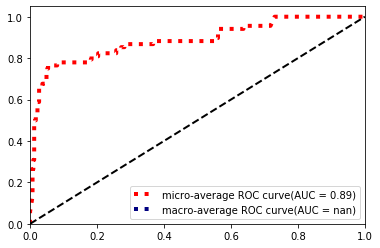

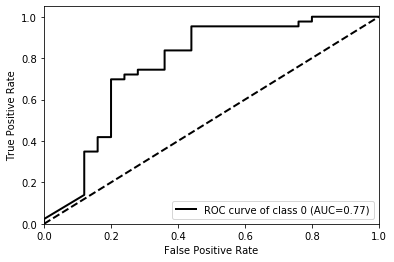

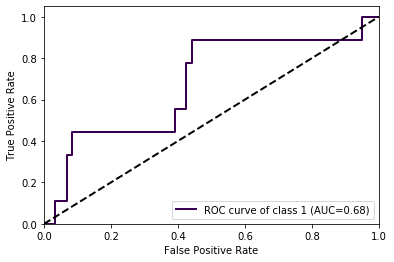

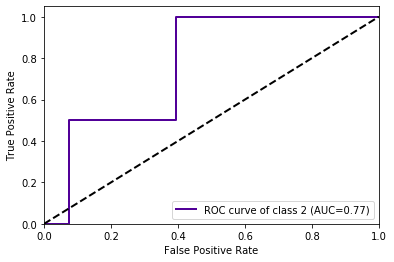

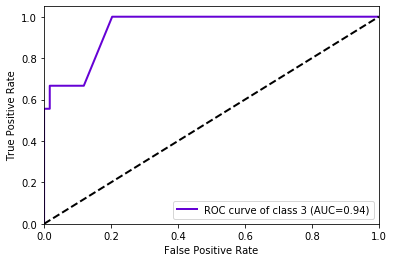

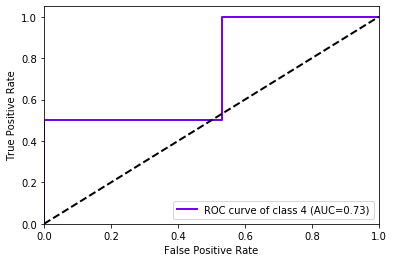

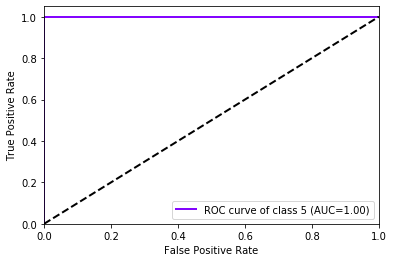

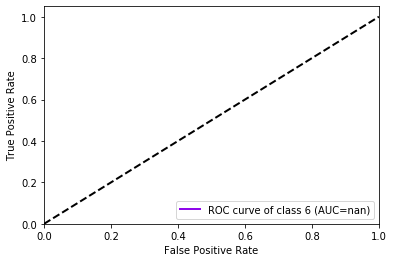

In [150]:
#env pert
stress = df[['Stress']]
labels = stress.loc[:, 'Stress'].unique()
labels = list(labels)
#gene_ex;
y = label_binarize(stress.values, classes=labels)

res = rocCurve(reduced, y)
plotROC(res, y.shape[1])


D:\ANACONDA\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
D:\ANACONDA\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


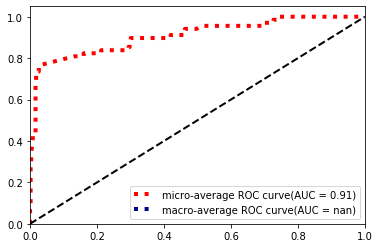

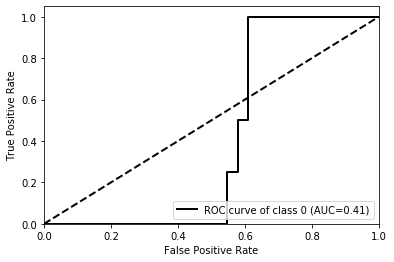

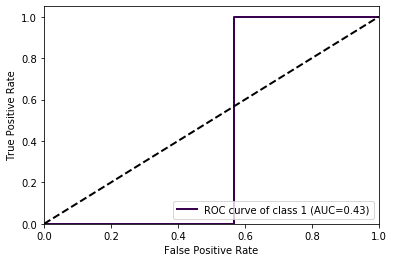

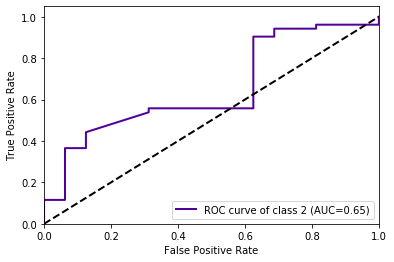

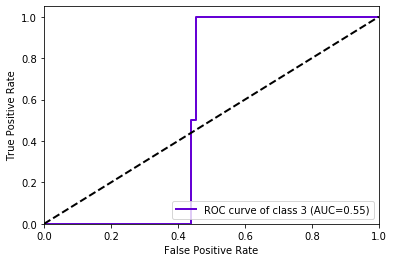

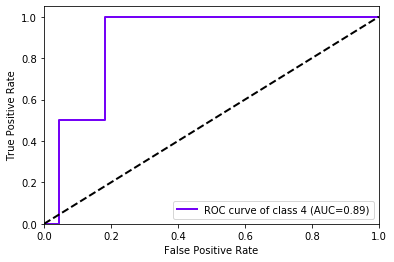

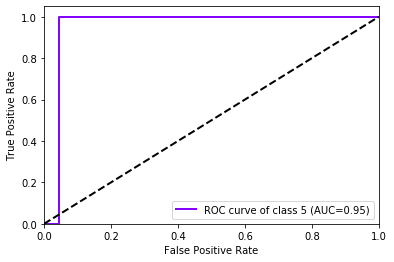

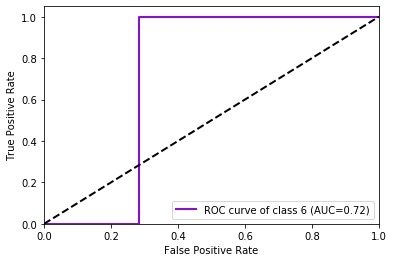

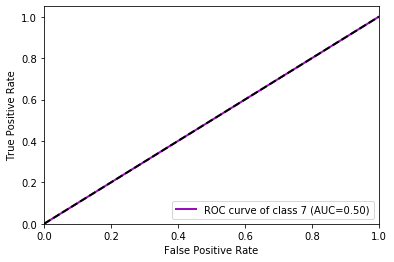

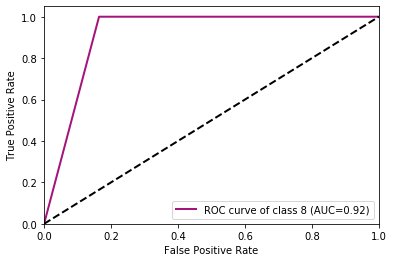

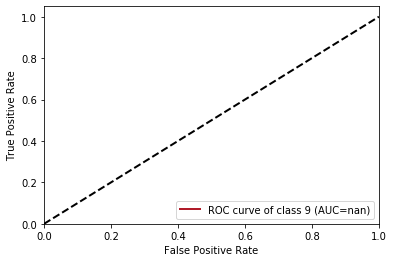

In [155]:
# Gene Pert
pert = df[['GenePerturbed']]
labels = pert.loc[:, 'GenePerturbed'].unique()
labels = list(labels)
#gene_ex;
y = label_binarize(pert.values, classes=labels)

res = rocCurve(reduced, y)
plotROC(res, y.shape[1])


## PR Curves

In [24]:
def prCurve(X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=67)
    
    clf = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=7))
    clf.fit(x_train,y_train)
    yScore = clf.decision_function(x_test)

    pr = {}
    recall = {}
    ave_pr = {}
    
    for i in range(Y.shape[1]):
        pr[i], recall[i], _ = precision_recall_curve(y_test[:,i], yScore[:, i])
        ave_pr[i] = average_precision_score(y_test[:, i], yScore[:, i])
        
    pr['micro'], recall['micro'], _ = precision_recall_curve(y_test.ravel(), yScore.ravel())
    ave_pr['micro'] = average_precision_score(y_test, yScore, average='micro')
    
    res = {
        'pr': pr,
        'recall': recall,
        'ave_pr': ave_pr
    }
    return res

In [30]:
def plotPR(r, numC):
    pr = r['pr']
    recall = r['recall']
    ave_pr = r['ave_pr']
    
    plt.figure()
    plt.step(recall['micro'], pr['micro'], where='post')
    plt.xlabel('Recall')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Average precision score. Micro-Average over all classes: Average Precision={0:0.2f}'.format(ave_pr['micro']))
    plt.show()
    lw=4
    cmap = plt.get_cmap('gnuplot')
    color = [cmap(i) for i in np.linspace(0, 1, 20)]
    
    for i in range(numC):
            c = 1
            if((c % 3) == 0):
                plt.figure()
                c = 1
            plt.plot(recall[i], pr[i], color=color[i], lw=lw, label='Precision recall for class {0} (area={1:0.2f})'
            ''.format(i, ave_pr[i]))
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc="lower right")
            plt.show()
            c = c + 1

/home/makaveli/python_projects/my_project_env/lib/python3.6/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


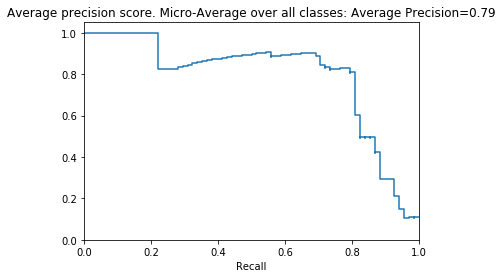

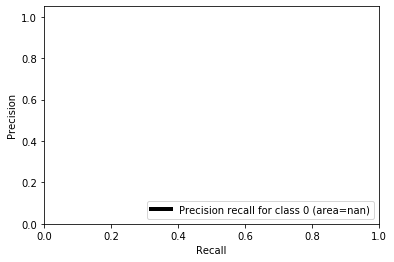

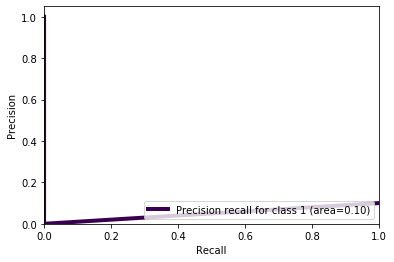

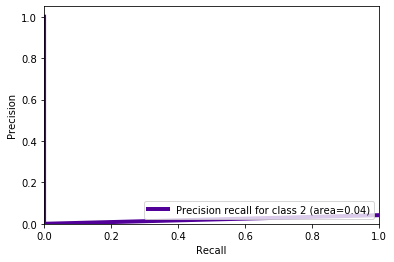

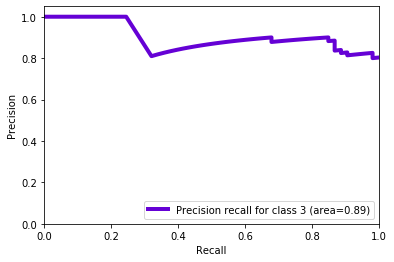

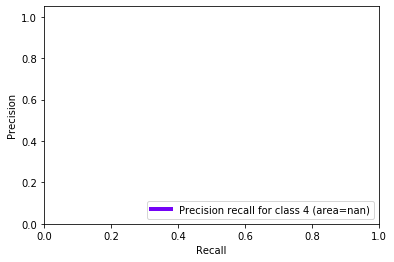

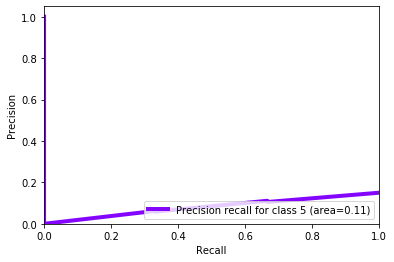

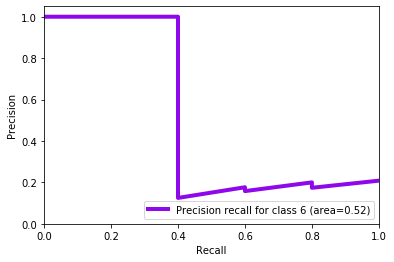

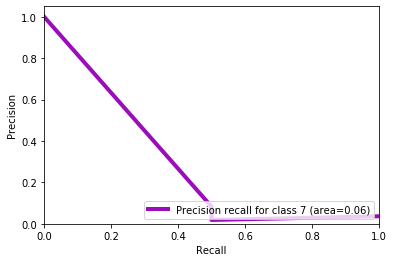

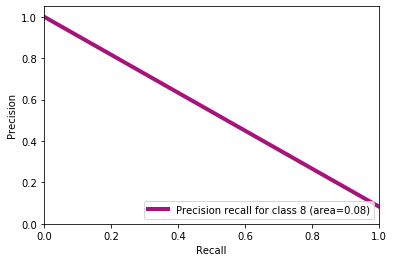

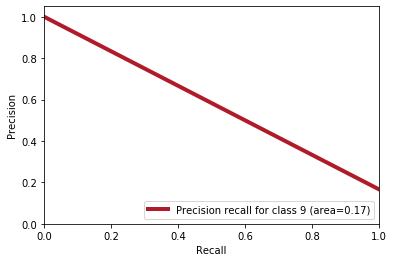

In [31]:
strain = df[['Strain']]
#gene_ex;
y = label_binarize(strain.values, classes=['BW25113', 'CG2', 'DH5alpha', 'MG1655', 'P2', 'P4X', 'W3110', 'rpoA14', 'rpoA27', 'rpoD3'])
#get non-zero features from number 1
l = lasso_res['best_est']
w = l.coef_
w = np.nonzero(w)
w = w[0]
reduced = gene_ex.iloc[:, w]

res = prCurve(reduced, y)
plotPR(res, y.shape[1])

# Problem 5

# Problem 6

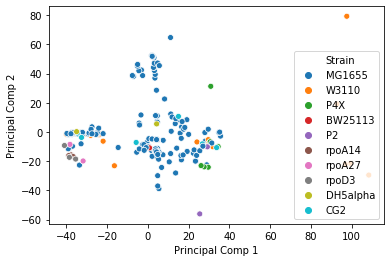

In [23]:
#pca
#strain
strain = df[['Strain']]
X = gene_ex.values
cols = gene_ex.columns
#standarize data
X = StandardScaler().fit_transform(X)
normX = pd.DataFrame(X, columns=cols)
#apply PCA
pcaStrain = PCA(n_components=2)
redStrain = pcaStrain.fit_transform(X)
#Visualize
strain_df = pd.DataFrame(data=redStrain, columns=['Principal Comp 1', 'Principal Comp 2'])
#strain_df.plot.scatter(x='Principal Comp 1', y='Principal Comp 2')
strain.reset_index(drop=True, inplace=True)
finalDF = pd.concat([strain_df, strain], axis=1)
sns.scatterplot(data=finalDF, x='Principal Comp 1', y='Principal Comp 2', hue='Strain')



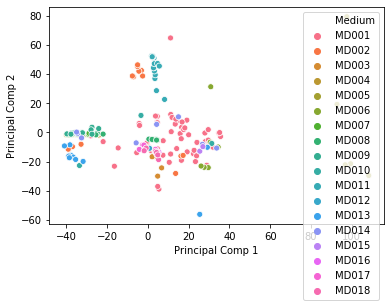

In [34]:
med = df[['Medium']]
med.reset_index(drop=True, inplace=True)
final2 = pd.concat([strain_df, med], axis=1)
sns.scatterplot(data=final2, x='Principal Comp 1', y='Principal Comp 2', hue='Medium')


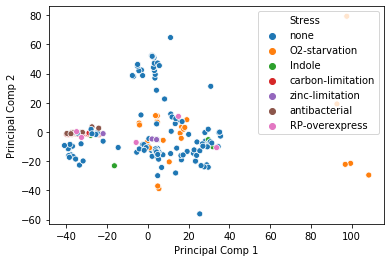

In [36]:
stress = df[['Stress']]
stress.reset_index(drop=True, inplace=True)
final3 = pd.concat([strain_df, stress], axis=1)
sns.scatterplot(data=final3, x='Principal Comp 1', y='Principal Comp 2', hue='Stress')

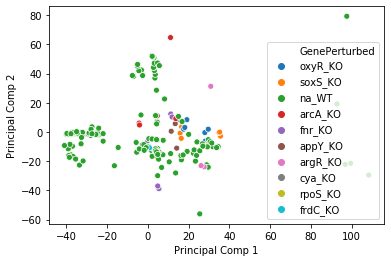

In [37]:
pert = df[['GenePerturbed']]
pert.reset_index(drop=True, inplace=True)
final4 = pd.concat([strain_df, pert], axis=1)
sns.scatterplot(data=final4, x='Principal Comp 1', y='Principal Comp 2', hue='GenePerturbed')

# Problem 7

0